In [55]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [24]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='test')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [34]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = './Dataset/SWAT/' # root path of data file
args.data_path = 'Normal.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 's' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './checkpoints' # location of model checkpoints

# args.data = 'ETTh1' # data
# args.root_path = './ETDataset/ETT-small/' # root path of data file
# args.data_path = 'ETTh1.csv' # data file
# args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
# args.target = 'OT' # target feature in S or MS task
# args.freq = 's' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
# args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 100 # input sequence length of Informer encoder
args.label_len = 50 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 's'

args.batch_size = 128
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 1
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1'


In [35]:
torch.cuda.is_available()

True

In [36]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [37]:
data_parser = {
    'custom':{'data':'Normal.csv','T':'FIT101','M':[37,37,37]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [38]:
data_info

{'data': 'Normal.csv', 'T': 'FIT101', 'M': [37, 37, 37]}

In [39]:
args.features

'M'

In [40]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [41]:
Exp = Exp_Informer

In [42]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
#     # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftM_sl100_ll50_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 297980
val 149040
test 449819
	iters: 100, epoch: 1 | loss: 0.2972454
	speed: 0.2016s/iter; left time: 449.1858s
	iters: 200, epoch: 1 | loss: 0.0862559
	speed: 0.2009s/iter; left time: 427.4540s
	iters: 300, epoch: 1 | loss: 0.0629812
	speed: 0.2016s/iter; left time: 408.7511s
	iters: 400, epoch: 1 | loss: 0.0976696
	speed: 0.2024s/iter; left time: 390.3229s
	iters: 500, epoch: 1 | loss: 0.0312701
	speed: 0.2028s/iter; left time: 370.7707s
	iters: 600, epoch: 1 | loss: 0.0185941
	speed: 0.2028s/iter; left time: 350.4788s
	iters: 700, epoch: 1 | loss: 0.0306596
	speed: 0.2031s/iter; left time: 330.6175s
	iters: 800, epoch: 1 | loss: 0.0196975
	speed: 0.2048s/iter; left time: 312.8910s
	iters: 900, epoch: 1 | loss: 0.0274812
	speed: 0.2040s/iter; left time: 291.3352s
	iters: 1000, epoch: 1 | loss: 0.0690869
	speed: 0.2

In [ ]:
prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

In [14]:
exp = Exp(args)
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, 0)
prediction = predict(exp, setting, True)

Use GPU: cuda:0
test 449720


In [43]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')




In [44]:
trues.shape

(449792, 1, 37)

In [47]:
preds.shape

(449792, 1, 37)

## Prediction

In [48]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

In [68]:
det = np.mean((preds[:,0,:]-trues[:,0,:])**2,1)

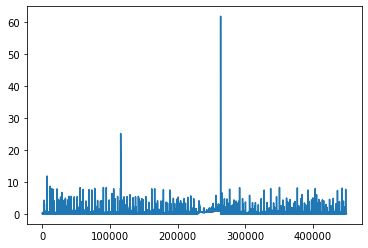

In [69]:
plt.plot(det)

In [52]:
# for i in range(0,len(det),100):
#     if np.mean(det[i:i+100]) < 1:
#         det[i:i+100] = 0

In [59]:
df_a = pd.read_csv('./Attack.csv',skiprows=1)
labels = np.load('labels.npy')
GT2 = df_a.loc[df_a['Normal/Attack'] == 'Attack'].index
GT2 = [GT2.values][0]

In [75]:
thr = 0.2
df_n = pd.read_csv('Normal.csv',skiprows=1)
df_a = pd.read_csv('Attack.csv',skiprows=1)

Alarms2 = (np.where(det >= thr))[0] 
N_Alarms2 = (np.where(det < thr))[0]

GT2 = df_a.loc[df_a['Normal/Attack'] == 'Attack'].index
GT2 = [GT2.values][0]

NT2 = df_a.loc[df_a['Normal/Attack'] == 'Normal'].index
NT2 = [NT2.values][0]


TP2 = list(set(Alarms2.tolist()) & set((GT2.tolist())))
TN2 = list(set(N_Alarms2.tolist()) & set((NT2.tolist())))
FP2 = list(set(Alarms2.tolist()) & set((NT2.tolist())))
FN2 = list(set(N_Alarms2.tolist()) & set((GT2.tolist())))

PRE2 = len(TP2)/(len(TP2)+len(FP2))
REC2 = len(TP2)/(len(TP2)+len(FN2))
F12 = 2*PRE2*REC2/(PRE2+REC2)

print(PRE2,REC2,F12)

0.8284845568291189 0.6934146207502608 0.7549557989575132


In [ ]:
np.save("detections.npy",det)

In [ ]:
thr = 0.975
df_n = pd.read_csv('Normal.csv',skiprows=1)
df_a = pd.read_csv('Attack.csv',skiprows=1)



OTP = 0
OTN = 0
OFP = 0
OFN = 0



GT = df_a.loc[df_a['Normal/Attack'] == 'Attack'].index
NT = df_a.loc[df_a['Normal/Attack'] == 'Normal'].index

# det = np.random.random((len(GT.values)+len(NT.values),1))

GT2 = [GT.values][0] - 100
NT2 = [NT.values][0] - 100

gts = set((GT2.tolist()))
nts = set((NT2.tolist()))

for i in range(0,len(det),win):
    print(i)
    Alarms2= i+(np.where(det[i:i+win] >= thr))[0] 
    N_Alarms2= i+(np.where(det[i:i+win] < thr))[0]
    
    
    
    TP2 = list(set(Alarms2.tolist()) & gts)
    TN2 = list(set(N_Alarms2.tolist()) & nts)
    FP2 = list(set(Alarms2.tolist()) & nts)
    FN2 = list(set(N_Alarms2.tolist()) & gts)
    
    if len(TP2) > 0:
        OTP+= len(gts & set(list(np.arange(i,i+win))))
        OFN+=0
    else:
        OTP += len(TP2)
        OFN += len(FN2)
    OTN += len(TN2)
    OFP += len(FP2)
        
    





PRE2 = OTP/(OTP+OFP)
REC2 = OTP/(OTP+OFN)
F12 = 2*PRE2*REC2/(PRE2+REC2)

print(PRE2,REC2,F12)